In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
from simple_pid import PID


In [3]:
# !! modify these as appropiate

home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/bench_model/PPO/PPO_lorenz-v0_4ecf0f74_2020-01-30_14-38-59awtqn03k/checkpoint_228/checkpoint-228"

In [4]:
# Some delightfully ugly python to infer where everything else is...
csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
save_name = checkpoint_path.split('/')[-3]
expr_file = "/experiment_state-" + save_name[-27:-8] + ".json"
expr_path = '/'.join(checkpoint_path.split('/')[:-3]) + expr_file

expr_data = json.load(open(expr_path))
config = expr_data['checkpoints'][-1]['config']
env_name = config['env']


df = pd.read_csv(csv_path)
#df

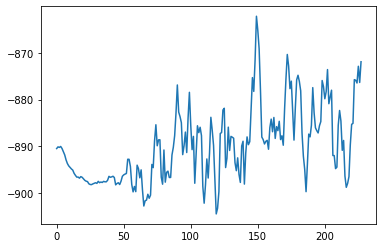

In [4]:
plt.plot(df['episode_reward_mean'])

In [6]:
ray.shutdown()
ray.init()

# !! change this line to reflect the algorithm you used
trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)
trainer.restore(checkpoint_path)

2020-01-30 15:11:36,657	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-01-30 15:11:36,659	INFO resource_spec.py:216 -- Starting Ray with 6.69 GiB memory available for workers and up to 3.36 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-01-30 15:11:37,081	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-01-30 15:11:37,102	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-01-30 15:11:41,444	INFO trainable.py:346 -- Restored from checkpoint: /home/sgillen/work/seagul/seagul/notebooks/lorenz/data/bench_model/PPO/PPO_lorenz-v0_4ecf0f74_2020-01-30_14-38-59awtqn03k/checkpoint_228/checkpoint-228
2020-01-30 15:11:41,446	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 228, '_timesteps_

In [71]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

#env = gym.make(env_name)
#env.unwrapped.reset_model = det_reset_model

# !! this needs to reflect the environemnt you trained in
env = gym.make("lorenz-v0")
env._max_episode_steps = 100000
obs = env.reset()


pid_x = PID(.1, 0.01, 0.01, setpoint=0, sample_time=0)
pid_y = PID(.1, 0.01, 0.01, setpoint=0, sample_time=0)
pid_z = PID(.1, 0.01, 0.01, setpoint=0, sample_time=0)




action_hist = []
m_act_hist = []
obs_hist = []
reward_hist = []

done = False
while not done:
    # for some algorithms you can get the sample mean out, need to change the value on the index to match your env for now
    # mean_actions = out_dict['behaviour_logits'][:17]
    # actions = trainer.compute_action(obs.flatten())
    
    sampled_actions, _ , out_dict = trainer.compute_action(obs.flatten(),full_fetch=True)
    
    #actions = sampled_actions
    actions = np.array([pid_x(obs[0]), pid_y(obs[1]), pid_z(obs[2])])
    actions*=5
    #actions = np.zeros(3)
    #actions = -obs
   
    
    obs, reward, done, _ = env.step(np.asarray(actions))
    
    # !! uncomment to render
    #env.render()
    
    action_hist.append(np.copy(actions))
    obs_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))

    if done:
        break

print(sum(reward_hist))
print(len(obs_hist))
#plt.plot(action_hist)
#plt.figure()
#plt.figure()
#plt.plot(obs_hist)
#plt.figure()

/home/sgillen/work/seagul/seagul/envs/simple_nonlinear/lorenz.py:116: RuntimeWarning: overflow encountered in double_scalars
  ydot = self.r * q[0] - q[1] - q[0] * q[2] - u[1]
/home/sgillen/work/seagul/seagul/envs/simple_nonlinear/lorenz.py:117: RuntimeWarning: overflow encountered in double_scalars
  zdot = q[0] * q[1] - self.b * q[2] - u[2]
/home/sgillen/work/seagul/seagul/envs/simple_nonlinear/lorenz.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ydot = self.r * q[0] - q[1] - q[0] * q[2] - u[1]
/home/sgillen/work/seagul/seagul/envs/simple_nonlinear/lorenz.py:158: RuntimeWarning: invalid value encountered in add
  return s0 + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
/home/sgillen/miniconda3/envs/ray/lib/python3.6/site-packages/gym/spaces/box.py:102: RuntimeWarning: invalid value encountered in greater_equal
  return x.shape == self.shape and np.all(x >= self.low) and np.all(x <= self.high)


ValueError: ('Observation outside expected value range', Box(3,), array([nan, nan, nan]))

In [70]:
# Reminder that the bahavior logits that come out are the mean and logstd (not log mean, despite the name logit)
#trainer.compute_action(obs, full_fetch=True)

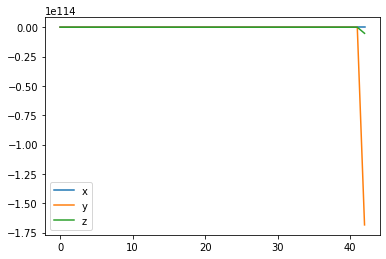

In [74]:
plt.plot(obs_hist)
plt.legend(['x', 'y', 'z'])

Text(0.5, 0.92, 'phase diagram, No control')

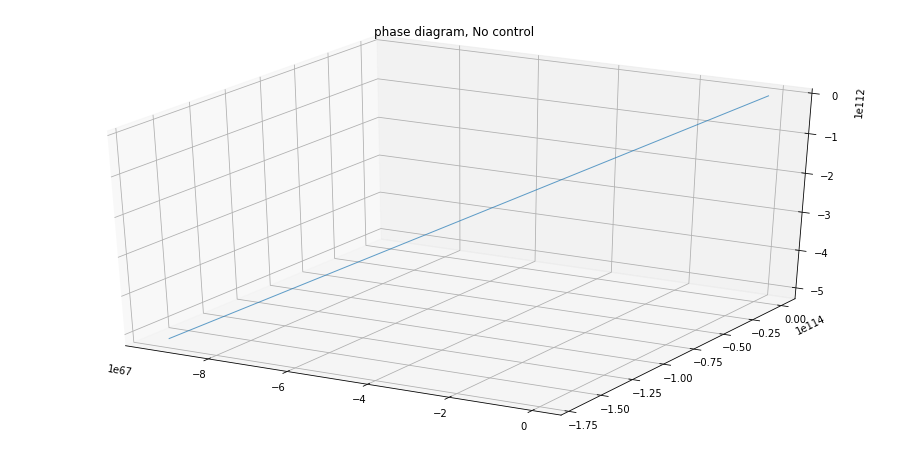

In [75]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram, No control')


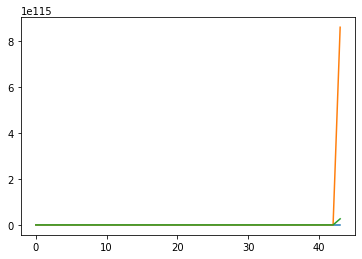

In [76]:
plt.plot(action_hist)